# Workshop on how to update Kernels to use Parcels v4

As mentioned in the presentation, the main changes to Kernels in Parcels v4 are:

- In Kernels, use actual dates, rather than seconds from start of FieldSet.

- `particle.dt` is now a `np.timedelta64`. Be aware when you do `x = v * dt`!

- The 'signature' of the Kernel changes from `Kernel(particle, fieldset, time)` to `Kernel(particles, fieldset)`, so no more `time`. Use `particle.time` instead.

- `particle_dlon` etc. has been changed to `particle.dlon`.

- The `particle.delete()` method has been removed. Delete particles by setting their state to `StatusCode.Delete`.

- Kernels now run as separate functions, not as one large concatenated function. This means that variables defined in one Kernel are not available in the next Kernel.

- No more `if`-statements. Use `np.where` instead.

- Support for python functions in Kernels.

- Support for arrays and `for`-loops in Kernels.

## Simple Kernels that operate on all Particles

Many Kernels will be easy to update, as they operate on all particles in the same way. For example, a Kernel that moves particles eastward by 1 m/s can be updated as follows:

```python
def MoveEast(particles, fieldset):
    dt = particles.dt / np.timedelta64(1, 's')  # Convert dt to seconds
    particles.dlon += 1 * dt
```

Note that in the above code, we are using the `dt` variable to represent the time step as a `float`, which is needed because `particles.dlon` is also a `float`. We are still considering how to make this more elegant for the final release of Parcels v4.

#### **Exercise**: Convert the RK2 and Lorenz Kernels from Session 2 yesterday to the new format and test whether they work.

In order to run them, you will also need to create a new `FieldSet`. The easiest way to do that is using the new `FieldSet.from_copernicusmarine()` method:

```python
example_dataset_folder = download_example_dataset("CopernicusMarine_data_for_Argo_tutorial")
ds_cm = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
fieldset = FieldSet.from_copernicusmarine(ds_cm)
```

The code above downloads a (very) small region in the Agulhas current. If this does not work for you, you could use the [`copernicusmarine` toolbox](https://help.marine.copernicus.eu/en/articles/7949409-copernicus-marine-toolbox-introduction) to download a different region. You'll need to have a login for the Copernicus Marine Service, but you can create one for free [here](https://marine.copernicus.eu/).

You can then download the data with e.g. this script:

```python
import copernicusmarine

for var, fname in zip((["uo", "vo"], ["thetao"], ["so"]), ("cur", "thetao", "so")):
    copernicusmarine.subset(
        dataset_id=f"cmems_mod_glo_phy-{fname}_anfc_0.083deg_P1D-m",
        variables=var,
        minimum_longitude=31,  # adjust to your region of interest
        maximum_longitude=33,  # adjust to your region of interest
        minimum_latitude=-33,  # adjust to your region of interest
        maximum_latitude=-30,  # adjust to your region of interest
        start_datetime="2024-01-01T00:00:00",
        end_datetime="2024-02-01T00:00:00",
        minimum_depth=0,
        maximum_depth=2000,  # adjust to your depth of interest
        username=#YOUR_USERNAME#,
        password=#YOUR_PASSWORD#,
        coordinates_selection_method="outside",
    )
```

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.
INFO: Output files are stored in /Users/erik/Codes/10year-anniversary-session4/solutions/output/AdvectionRK2_simulation.zarr
100%|██████████| 604800.0/604800.0 [00:01<00:00, 331786.31it/s]


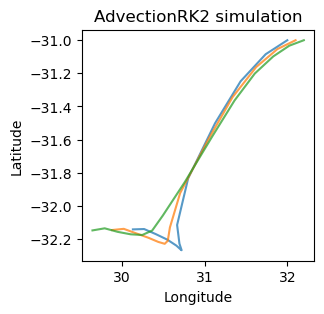

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from parcels import download_example_dataset, FieldSet, ParticleSet, ParticleFile

# Use the code below to set up the RK2 advection example
example_dataset_folder = download_example_dataset("CopernicusMarine_data_for_Argo_tutorial")
ds_cm = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
fieldset = FieldSet.from_copernicusmarine(ds_cm)

npart = 3
pset = ParticleSet(fieldset, lon=np.linspace(32, 32.2, npart), lat=[-31]*npart, depth=[5]*npart)

# Your answer here
def AdvectionRK2(particles, fieldset):  # Remove time from arguments
    """Advection of particles using second-order Runge-Kutta integration."""
    dt = particles.dt / np.timedelta64(1, "s")  # convert dt to float in seconds
    (u1, v1) = fieldset.UV[particles]
    lon1, lat1 = (particles.lon + u1 * 0.5 * dt, particles.lat + v1 * 0.5 * dt)  # use dt in float
    (u2, v2) = fieldset.UV[particles.time + 0.5 * particles.dt, particles.depth, lat1, lon1, particles]
    particles.dlon += u2 * dt  # Use particle.dlon and dt in floats
    particles.dlat += v2 * dt

pfile = ParticleFile("output/AdvectionRK2_simulation.zarr", outputdt=np.timedelta64(12, "h"))

pset.execute(AdvectionRK2, runtime=np.timedelta64(7, "D"), dt=np.timedelta64(12, "h"), output_file=pfile)

# Open the dataset and visualise the results
ds = xr.open_zarr("output/AdvectionRK2_simulation.zarr")
fig = plt.figure(figsize=(3,3))
plt.title('AdvectionRK2 simulation')
plt.plot(ds.lon.T, ds.lat.T, alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Use the code below to set up the Lorenz model advection example

from parcels import Particle, Variable

# Parcels v4 doesn't yet have a 'from_data` method for FieldSet, so we reuse the FieldSet from the RK2 example
fieldset = FieldSet.from_copernicusmarine(ds_cm)
fieldset.add_constant('rho', 28.)     # Rayleigh number
fieldset.add_constant('sigma', 10.)   # Prandtl number
fieldset.add_constant('beta', 8./3.)  # Geometric factor

# Your answer here

# Define the Lorenz kernel using the Explicit Euler scheme
def LorenzKernelEE(particles, fieldset):
    """Lorenz attractor kernel (Explicit Euler)"""
    dt = particles.dt / np.timedelta64(1, 's')  # Convert dt to float in seconds
    x = particles.lon
    y = particles.lat
    z = particles.depth
    # Euler integration for Lorenz equations
    particles.dlon += fieldset.sigma * (y - x) * dt      # dx/dt
    particles.dlat += (x * (fieldset.rho - z) - y) * dt  # dy/dt
    particles.ddepth += (x * y - fieldset.beta * z) * dt # dz/dt

# Define initial positions for two Lorenz particles
initial_position = [[0,0],       # x-coordinates
                    [1,1],       # y-coordinates
                    [1.05, 2.5]] # z-coordinates (slightly different to show sensitivity to initial conditions)

runtime = np.timedelta64(50000, 'ms')  # Total simulation time
dt = np.timedelta64(10, 'ms')          # Time step for integration
outputdt = dt                          # Output interval
chunks = int(runtime/outputdt)         # Chunk size (important for fast IO)

LorenzParticle = Particle.add_variable(Variable("energy", np.float64))

# Create a ParticleSet for the Lorenz system
pset = ParticleSet(fieldset=fieldset, pclass=LorenzParticle,
    lon=[initial_position[0]],
    lat=[initial_position[1]],
    depth=[initial_position[2]])

pset.update_dt_dtype(dt.dtype)  # Set the dt dtype to milliseconds

pfile = ParticleFile("output/lorenz.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

pset.execute(LorenzKernelEE, runtime=runtime, dt=dt, output_file=pfile)


INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.
INFO: Output files are stored in /Users/erik/Codes/10year-anniversary-session4/solutions/output/lorenz.zarr
100%|█████████▉| 49.99999999999862/50.0 [00:28<00:00,  1.73it/s]  


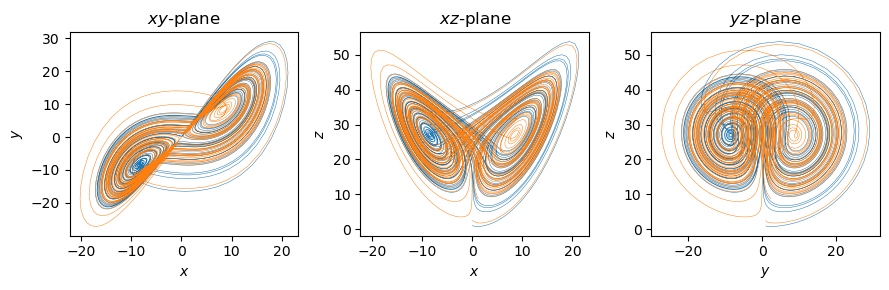

In [10]:

# Plot the Lorenz trajectories in 2D projections
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
ds_ee = xr.open_zarr("output/lorenz.zarr", decode_timedelta=True)

# XY plane
ax[0].plot(ds_ee.lon.T, ds_ee.lat.T, lw=0.35)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title(r'$xy$-plane')

# XZ plane
ax[1].plot(ds_ee.lon.T, ds_ee.z.T, lw=0.35)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$z$')
ax[1].set_title(r'$xz$-plane')

# YZ plane
ax[2].plot(ds_ee.lat.T, ds_ee.z.T, lw=0.35)
ax[2].set_xlabel(r'$y$')
ax[2].set_ylabel(r'$z$')
ax[2].set_title(r'$yz$-plane')

plt.tight_layout()
plt.show()

One of the very nice features of pure-python Kernels is that you can now use any python function in your Kernel. For example, you can use the `gsw` toolbox to compute density from temperature and salinity.

#### **Exercise**: write a Kernel that computes density from temperature and salinity using the `gsw` toolbox.

For this, you can use the same `fieldset` as above, which contains temperature and salinity fields.

In [11]:
fieldset = FieldSet.from_copernicusmarine(ds_cm)

GSWParticle = Particle.add_variable(
    [
        Variable("temp", dtype=np.float32, initial=np.nan),
        Variable("salt", dtype=np.float32, initial=np.nan),
        Variable("density", dtype=np.float32, initial=np.nan),
    ]
)

# Initiate one sample point in the Agulhas Current
pset = ParticleSet(
    fieldset=fieldset,
    pclass=GSWParticle,
    lon=[32],
    lat=[-31],
    depth=[200],
)

# Your answer here

def ParcelsGSW(particles, fieldset):
    import gsw

    particles.temp = fieldset.thetao[particles]
    particles.salt = fieldset.so[particles]
    pressure = gsw.p_from_z(-particles.depth, particles.lat)
    particles.density = gsw.density.rho(particles.salt, particles.temp, pressure)

pset.execute(ParcelsGSW, runtime=np.timedelta64(1, "s"), dt=np.timedelta64(1, "s"))

print(
    f"Temperature: {pset.temp[0]:.2f}, Salinity: {pset.salt[0]:.2f}, Density: {pset.density[0]:.2f}"
)

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.
100%|██████████| 1.0/1.0 [00:00<00:00, 35.60it/s]
Temperature: 16.32, Salinity: 35.52, Density: 1026.83


## More complex Kernels that operate on subsets of Particles

One of the biggest changes you may have to deal with is the removal of `if`-statements in Kernels. Since the Kernel now operates on all particles at once, `if`-statements are not allowed anymore. Instead, you should use `np.where` to operate on subsets of particles. For example, a Kernel that deletes particles older than 10 can be written as:

```python
def DeleteOldParticles(particles, fieldset):
    particles.state = np.where(particles.age > 10,
                               StatusCode.Delete,
                               particles.state)
```

#### **Exercise**: Convert a Kernel with `if`-statements to the new format using `np.where`

For this, you should ideally take a Kernel that you have written before. If you haven't written one before, you can first make one in the v3 format, and then convert it to the v4 format.

In [12]:
# Your answer here

## Fallback option, looping over particles

Of course, if it's really impossible to avoid `if`-statements, you can always loop over particles in a Kernel. This is less efficient, but it works. Here's an example of how to do this:

```python
def DeleteOldParticles_forloop(particles, fieldset):
    for p in particles:
        if p.age > 10:
            p.state = StatusCode.Delete
```

Note that we are exploring whether `numba` can be used to speed up such Kernels, but this is not yet implemented.

#### **Exercise**: Test if your v4-kernel also works with a `for`-loop.

Explore the difference in speed between the `np.where` and the `for`-loop version of your Kernel. For this, you will probably have to run it with thousands of particles.

If you want, you could even try to get `numba` to work with the `for`-loop version of your Kernel. We'd be very keen to hear how that goes!

In [13]:
# Your answer here

## Extra: write custom Interpolators

One of the new features in Parcels v4 is the ability to write custom Interpolators. This is a bit more advanced, but if you are interested, you can try it out yourself. 

We are still working on the definitive API, but for now an Interpolator function must have the following signature:

```python

def my_interpolator(
    field: Field,
    ti: int,
    position: dict[_XGRID_AXES, tuple[int, float | np.ndarray]],
    tau: np.float32 | np.float64,
    t: np.float32 | np.float64,
    z: np.float32 | np.float64,
    y: np.float32 | np.float64,
    x: np.float32 | np.float64,
) -> np.float32 | np.float64:
    return 0.0
```
Where of course an Interpolator that always returns 0.0 is not very useful, so the function itself will be much more complex. 

The `position` argument is a dictionary that contains, for each dimension, a tuple of the index of the grid cell and the relative position within that grid cell. For example, for a 2D field, `position` could be:

```python
{
    'X': (10, 0.3),  # 10th grid cell in X direction, 30% into the cell
    'Y': (20, 0.7)   # 20th grid cell in Y direction, 70% into the cell
}
```

And `ti` and `tau` are the same for the time dimension. A very simple horizontal linear interpolation could thus be written as:

```python
def linear_interpolator(field, ti, position, tau, t, z, y, x):
    """Bilinear interpolation on a rectilinear grid."""
    xi, xsi = position["X"]
    yi, eta = position["Y"]

    data = field.data.data[ti:ti + 2, zi, yi:yi + 2, xi:xi + 2]
    val_t0 =(
        (1 - xsi) * (1 - eta) * data[0, 0, 0, 0]
        + xsi * (1 - eta) * data[0, 0, 0, 1]
        + xsi * eta * data[0, 0, 1, 1]
        + (1 - xsi) * eta * data[0, 0, 1, 0]
    )

    val_t1 =(
        (1 - xsi) * (1 - eta) * data[1, 0, 0, 0]
        + xsi * (1 - eta) * data[1, 0, 0, 1]
        + xsi * eta * data[1, 0, 1, 1]
        + (1 - xsi) * eta * data[1, 0, 1, 0]
    )
    value = (val_t0 * (1 - tau) + val_t1 * tau)
    return value.compute() if is_dask_collection(value) else value
```

#### **Exercise**: Write a custom Interpolator function that does something useful.

You can test your interpolator by setting it as the `Field.interp_method`:

```python
fieldset.U.interp_method = my_interpolator
```

In [14]:
# Your answer here